<a href="https://colab.research.google.com/github/congdqsmx/RS06/blob/master/gbdt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GDBT + LR 算法


In [1]:
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
iris = datasets.load_iris()
X = iris.data
y = iris.target
# 使用GBDT进行分类
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,max_depth=1, random_state=0)
scores = cross_val_score(clf, X, y, cv=3)
print('GBDT准确率：%0.4lf' %scores.mean())

GBDT准确率：0.9533


GBDT回归MSE： 25.058198832151774
各特征的重要程度： [2.87989834e-02 1.92927107e-04 3.64242465e-03 2.24190972e-04
 3.23741983e-02 4.87031572e-01 1.00749594e-02 3.91799508e-02
 1.90109083e-03 1.68819726e-02 3.04022815e-02 1.08378247e-02
 3.38457624e-01]


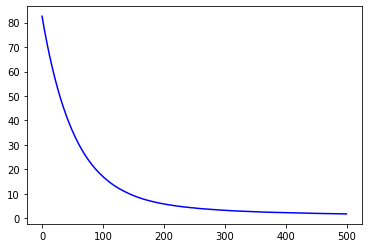

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# 波士顿房价回归数据集
boston = load_boston()  
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.1, random_state=0)  
clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01,max_depth=4,min_samples_split=2,loss='ls')
clf.fit(X_train, y_train)
print('GBDT回归MSE：',mean_squared_error(y_test, clf.predict(X_test)))
#print('每次训练的得分记录：',clf.train_score_)
print('各特征的重要程度：',clf.feature_importances_)
# 每次训练，增加新的CART树，带来的训练得分变化
# train_score_:表示在样本集上每次迭代以后的对应的损失函数值。
plt.plot(np.arange(500), clf.train_score_, 'b-')  
#print(clf.train_score_)
plt.show()

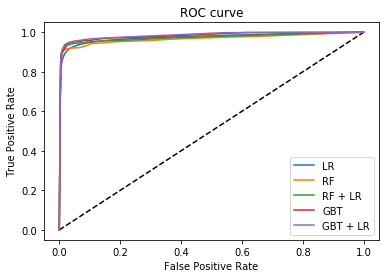

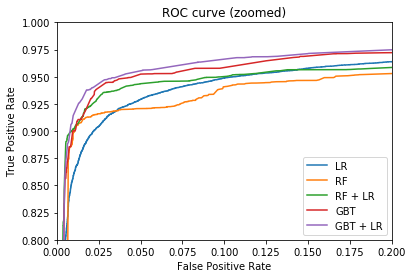

In [3]:
"""
	GBDT+LR算法Demo演示
	随机生成二分类样本8万个，每个样本20个特征
	采用RF，RF+LR，GBDT，GBDT+LR进行二分类预测
"""

import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
# 生成样本集
X, y = make_classification(n_samples=80000, n_features=20)
#print(X)
# 将样本集分成测试集和训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# 再将训练集拆成两个部分（GBDT/RF，LR）
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)

# 基于随机森林的监督变换
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf.fit(X_train, y_train)
# 得到OneHot编码
rf_enc = OneHotEncoder(categories='auto')
rf_enc.fit(rf.apply(X_train))
# 使用OneHot编码作为特征，训练LR
rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
# 使用LR进行预测
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# 基于GBDT监督变换
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(X_train, y_train)
# 得到OneHot编码
grd_enc = OneHotEncoder(categories='auto')

#temp = grd.apply(X_train)
np.set_printoptions(threshold=np.inf)  
grd_enc.fit(grd.apply(X_train)[:, :, 0])
#print(grd_enc.get_feature_names()) # 查看每一列对应的特征
# 使用OneHot编码作为特征，训练LR
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
# 使用LR进行预测
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# 直接使用GBDT进行预测
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# 直接使用RF进行预测
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_skl = roc_curve(y_test, y_pred_rf)

# 直接使用LR进行预测
LR = LogisticRegression(n_jobs=4, C=0.1, penalty='l2')
LR.fit(X_train, y_train)
y_pred = LR.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
#auc = roc_auc_score(Y_test, Y_pred)
#print('LogisticRegression: ', auc)


#print(fpr_rf,'\n', tpr_rf,'\n', thresholds_skl)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 将左上角放大显示
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()